# Feature Engineering for Standup Scripts
## Goal: Generate useful features related to standup comedy style.

## Table of Contents

   - [x] [imports](#imports)
   - [x] [prepare the data](#prepare-the-data)
   - [x] [word lengths](#word-lengths)
   - [x] [distinct words](#distinct-words)
   - [x] [words per minute and sentences per minute](#words-per-minute-and-sentences-per-minute)
   - [ ] [repetition and phrases](#repetition-and-phrases)
       - [with gensim](#with-gensim)
       - [with sklearn](#with-sklearn)
   - [x] [profanity](#profanity)
   - [ ] [part-of-speech frequencies](#part-of-speech-frequencies)
   - [ ] [sentence structure](#sentence-structure)
   - [ ] [point of view](#point-of-view)
   - [ ] [cosine similarities](#cosine-similarities)
   - [playground](#playground)

## imports 


In [1]:
import pickle
import numpy as np
import pandas as pd
from datetime import date
import json
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import re
from collections import Counter, defaultdict
import itertools
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
import gensim
from gensim.corpora.dictionary import Dictionary
import spacy

import warnings
warnings.filterwarnings('ignore')

In [2]:
sw = stopwords.words("english")

In [3]:
transcripts_df = pd.read_pickle('../data/transcripts_raw_df.pickle')

In [4]:
with open(f'../data/imdb_title_results_2022-05-23.pickle', 'rb') as file:
    show_meta = pickle.load(file)

In [5]:
with open(f'../data/metascripts_df_2022-05-28.pickle', 'rb') as file:
    metascripts = pickle.load(file)

In [6]:
with open("../data/profane_to_replace.pickle", 'rb') as file:
    to_replace = pickle.load(file)
    
with open("../data/profane_replace_with.pickle", 'rb') as file:
    replace_with = pickle.load(file)

In [7]:
nonenglish_shows = ['BILL BURR: WHY DO I DO THIS (2008) – Testo italiano completo',
                   'DOUG STANHOPE: NO REFUNDS (2007) – Trascrizione italiana',
                   'GEORGE CARLIN: JAMMING IN NEW YORK (1992) – Testo italiano completo',
                   'GEORGE CARLIN: YOU ARE ALL DISEASED (1999) – Testo italiano completo',
                   'GEORGE CARLIN: IT’S BAD FOR YA! (2008) – Testo italiano completo',
                   'DAVE CHAPPELLE: THE BIRD REVELATION (2017) – Transcripción completa']

In [8]:
metascripts = metascripts[~metascripts['description'].isin(nonenglish_shows)]

In [9]:
metascripts.shape

(310, 24)

## prepare the data


In [10]:
# Replace bracket and parenthetical content from scripts
metascripts['transcript'] = (metascripts['transcript']
                                 .replace("\[.+?\]|\(.+?\)","", regex = True)
                                 .replace("\’|\‘", "'", regex = True)
                                 .replace("\“|\”", '"', regex = True)
                                 .replace(to_replace[0], replace_with[0], regex = True)
                                 .replace(to_replace[1], replace_with[1], regex = True)
                            )

In [11]:
# Fill censored words to clean up our profanity detection
profanity_fill = json.load(open('../data/profanity_fill.json'))

for key, value in profanity_fill.items(): 
    metascripts['transcript'] = metascripts['transcript'].str.replace(key, value, regex = False)

In [12]:
transcripts_dict = dict(zip(metascripts['description'].values, metascripts['transcript'].values))

In [13]:
descriptions = list(transcripts_dict.keys())
scripts = list(transcripts_dict.values())

In [14]:
parens = (re.findall(r"\(.+?\)", script) for script in scripts)
[(ind, len(matches)) for ind, matches in enumerate(parens) if len(matches) > 0]
parenscripts = (scripts[ind] for ind, matches in enumerate(parens) if len(matches) > 0)

## word lengths
word lengths are calculated as letters per word

   * tokenize words (allow apostrophes and dashes but not numbers)
   * do not lemmatize
   * do not remove stopwords
   
[to the top](#Feature-Engineering-for-Standup-Scripts)

In [15]:
bow_cased = [regexp_tokenize(transcript, r"[a-zA-Z]+") for description, transcript in transcripts_dict.items()]
bow_counter = [Counter(word.lower() for word in script_words) for script_words in bow_cased]

tokenized_list = [[word.lower() for word in script_words] for script_words in bow_cased]
dictionary = Dictionary(tokenized_list)
corpus = [dictionary.doc2bow(script) for script in tokenized_list]

In [16]:
word_lengths = [[len(word) for word in script_words] for script_words in tokenized_list]

In [17]:
metascripts['mean word length'] = [np.mean(script_word_lengths) for script_word_lengths in word_lengths]
metascripts['std word length'] = [np.std(script_word_lengths) for script_word_lengths in word_lengths]

for quantile in (0.25, 0.50, 0.75):
    metascripts[f'Q{quantile/0.25} word length'] = [np.quantile(script_word_lengths, quantile) for script_word_lengths in word_lengths]

metascripts['max word length'] = [np.max(script_word_lengths) for script_word_lengths in word_lengths]

## sentence lengths
sentence lengths are calculated as words per sentence

   * tokenize sentences and then count whitespaces
   * do not remove stopwords
   * get arrays so we can do mean, median, boxplot values, standard deviation
   
[to the top](#Feature-Engineering-for-Standup-Scripts)

In [18]:
sent_tokenized_list = [sent_tokenize(transcript) for description, transcript in transcripts_dict.items()]
sent_words_tokenized_list = [[regexp_tokenize(sent, r"['\-\w]+") for sent in sent_script] for sent_script in sent_tokenized_list]
sent_lengths = [[len(sent) for sent in script] for script in sent_words_tokenized_list]
sent_counts = [len(script) for script in sent_tokenized_list]

In [19]:
metascripts['mean sentence length'] = [np.mean(script_sent_lengths) for script_sent_lengths in sent_lengths]
metascripts['std sentence length'] = [np.std(script_sent_lengths) for script_sent_lengths in sent_lengths]

for quantile in (0.25, 0.50, 0.75):
    metascripts[f'Q{quantile/0.25} sentence length'] = [np.quantile(script_sent_lengths, quantile) for script_sent_lengths in sent_lengths]

metascripts['max sentence length'] = [np.max(script_sent_lengths) for script_sent_lengths in sent_lengths]

## distinct words
count distinct words in each show and normalize by determining the proportion of distinct words and distinct words per sentence

   * tokenize: allow apostrophes and dashes but not numbers 
   * lemmatize
   
[to the top](#Feature-Engineering-for-Standup-Scripts)

In [20]:
from nltk.stem.wordnet import WordNetLemmatizer

In [21]:
lemmatizer = WordNetLemmatizer()
lem_counter = [Counter(lemmatizer.lemmatize(word.lower()) for word in script_words) for script_words in bow_cased]

In [22]:
unique_word_counts = [len(script_lem_counts) for script_lem_counts in lem_counter]
total_word_counts = [np.sum([count for lem, count in script_lem_counts.items()]) for script_lem_counts in lem_counter]
unique_total_ratio = [unique/total for unique, total in zip(unique_word_counts, total_word_counts)]
unique_per_sent = [unique/sent_count for unique, sent_count in zip(unique_word_counts, sent_counts)]

In [23]:
metascripts['unique words'] = unique_word_counts
metascripts['total words'] = total_word_counts
metascripts['proportion unique words'] = unique_total_ratio
metascripts['unique words per sentence'] = unique_per_sent

## words per minute and sentences per minute

In [24]:
word_tok_scripts = [regexp_tokenize(script, r"[\w'-]+") for script in scripts]
words_per_minute = [len(script_words)/minutes for script_words, minutes in zip(word_tok_scripts, metascripts['runtimeMins'].values)]

sent_tok_scripts = [sent_tokenize(script) for script in scripts]
sent_per_minute = [len(script_sentences)/minutes for script_sentences, minutes in zip(sent_tok_scripts, metascripts['runtimeMins'].values)]

In [25]:
metascripts['words per minute'] = words_per_minute
metascripts['sentences per minute'] = sent_per_minute

## repetition and phrases
I've found three ways to get ngrams:

   1. Using Gensim's [Phrases model](https://radimrehurek.com/gensim_3.8.3/models/phrases.html) iteratively across the corpus, where the kth iteration creates a kgram
   2. Using one of SKLearn's text feature extraction modules [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) or [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer), which is equivalent to the CountVectorizer followed by the [TfidfTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer)
   
[to the top](#Feature-Engineering-for-Standup-Scripts)

### with gensim

In [26]:
from gensim.models import Phrases

In [27]:
tok_scripts = [regexp_tokenize(transcript, r"['\-\w]+") for description, transcript in transcripts_dict.items()]
docs_lem = [[lemmatizer.lemmatize(tok.lower()) for tok in transcript] for transcript in tok_scripts]
docs_no_lem = [[tok.lower() for tok in transcript] for transcript in tok_scripts]

In [28]:
# still not picking up anything greater than a bigram. May need to reduce the Phrases threshold.

def append_ngrams(docs, ngram):
    for idx in range(len(docs)):
        for token in ngram[docs[idx]]:
            if '_' in token:
                # if token is an ngram, add to document.
                docs[idx].append(token)
    return docs

def make_ngrams(tok_corpus, with_dict = False, lemmatize = True, max_n = 2, min_count = 5, **kwargs):
    ngram_dict = {}
    if lemmatize:
        docs = [[lemmatizer.lemmatize(tok.lower()) for tok in transcript] for transcript in tok_corpus]
    else:
        docs = [[tok.lower() for tok in transcript] for transcript in tok_corpus]
    for n in range(2, max_n+1):
        if n == 2:
            ngram_dict[f'{str(n)}grams'] = Phrases(docs, min_count = min_count, **kwargs)
        else:
            ngram_dict[f'{str(n)}grams'] = Phrases(ngram_dict[f'{str(n-1)}grams'][docs], min_count = min_count, **kwargs)
    docs = append_ngrams(docs, ngram_dict[f'{str(max_n)}grams'])
    if with_dict:
        return docs, ngram_dict
    else:
        return docs

In [29]:
docs, ngram_dict = make_ngrams(tok_scripts, with_dict = True, lemmatize = True, max_n = 4, min_count = 1, threshold = 1)

In [30]:
ngram_dict

{'2grams': <gensim.models.phrases.Phrases at 0x26f72c47a60>,
 '3grams': <gensim.models.phrases.Phrases at 0x26f72c47af0>,
 '4grams': <gensim.models.phrases.Phrases at 0x26f72c47040>}

In [31]:
for ind in range(len(docs)):
    c = Counter(tok for tok in docs[ind] if re.search("(.+_){2}", tok))
    if len(c) > 0:
        print(c)

Counter({'__quarteroid__': 2})
Counter({'lick_my_ass': 2})


In [32]:
[(descriptions[ind], len(re.findall("what is that", script.lower()))) for ind, script in enumerate(scripts) if len(re.findall("what is that", script.lower())) > 0 ][15:19]

[('JIM NORTON: AMERICAN DEGENERATE (2013) – FULL TRANSCRIPT', 1),
 ('CHRIS D’ELIA: WHITE MALE. BLACK COMIC. (2013) – FULL TRANSCRIPT', 1),
 ('Bert Kreischer: Hey Big Boy (2020) – Transcript', 1),
 ('Marc Maron: End Times Fun (2020) – Full Transcript', 4)]

### with sklearn

In [33]:
# import pyLDAvis
# import pyLDAvis.sklearn
# pyLDAvis.enable_notebook()

# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.decomposition import LatentDirichletAllocation

In [34]:
# %%timeit
# ct_vectorizer = CountVectorizer(lowercase = True, 
#                              token_pattern = r"\b[a-zA-z][a-zA-Z\-']*\b", 
#                              ngram_range = (1, 4),
#                              stop_words = "english",
                             
#                             )
# scripts_tf = ct_vectorizer.fit_transform(scripts)

# tfidf_vectorizer = TfidfVectorizer(**ct_vectorizer.get_params())
# scripts_tfidf = tfidf_vectorizer.fit_transform(scripts)

In [35]:
# tfidf_vectorizer.get_feature_names_out()[8000:8015]

In [36]:
# scripts_tf

## profanity
There are several options for detecting profanity. Three prominent ones are

   - [x] [profanity-filter](#https://pypi.org/project/profanity-filter/): a sophisticated, word-list-based package with boolean methods like is_profane
   - [ ] [profanity-check](#https://pypi.org/project/alt-profanity-check/): a model-based approach to profanity detection compatible with spaCy
   - [ ] [better-profanity](#https://pypi.org/project/better-profanity/): another list-based approach, though less accurate than profanity-filter
   
profanity-filter is the most appropriate for this project. While a model-based approach is appealing, it's more likely to identify words or sentences as profane because the sentence has the structure of an insult. For instance, if a comedian says, "That guy is a dingleberry," profanity-check would flag it as profane, while profanity-filter would not.
   
[to the top](#Feature-Engineering-for-Standup-Scripts)

In [37]:
from profanityfilter import ProfanityFilter

In [38]:
pf = ProfanityFilter()
tok_scripts = [regexp_tokenize(transcript, r"\b[a-zA-Z'\w\-\*]+\b") for transcript in scripts]
tok_scripts_lc = [[token.lower() for token in script] for script in tok_scripts]
word_counts = [Counter(token for token in script) for script in tok_scripts_lc]

In [39]:
dictionary = Dictionary(tok_scripts_lc)
corpus = [dictionary.doc2bow(script) for script in tok_scripts_lc]

In [40]:
#[dictionary.id2token(token) for token in dictionary.iterkeys()]
corpus_overall_counts = {}
for bow in tqdm(corpus):
    for id, count in bow:
        if dictionary[id] in corpus_overall_counts.keys():
            corpus_overall_counts[dictionary[id]] += count
        else:
            corpus_overall_counts[dictionary[id]] = count

  0%|          | 0/310 [00:00<?, ?it/s]

In [41]:
# profane_dict = {word: pf.is_profane(word) for word in tqdm(corpus_overall_counts)}

In [42]:
# with open('../data/profanity_booleans_no_lemma.pickle', 'wb') as file:
#     pickle.dump(profane_dict, file)

In [43]:
with open('../data/profanity_booleans_no_lemma.pickle', 'rb') as file:
    profane_dict = pickle.load(file)

In [44]:
profanity_counts = {description: {word:count for word, count in script_counts.items() if profane_dict[word]} for script_counts, description in zip(word_counts,descriptions)}

KeyError: 'nigga-ttendant'

In [ ]:
profane_words = [sum(words.values()) for description, words in profanity_counts.items()]
total_words = [sum(script_word_counts.values()) for script_word_counts in word_counts]
profane_proportion = [profane/total for profane, total in zip(profane_words, total_words)]
profane_per_sent = [profane/sent_count for profane, sent_count in zip(profane_words, sent_counts)]
profane_per_min = [profane/minutes for profane, minutes in zip(profane_words, metascripts['runtimeMins'].values)]

In [ ]:
metascripts['profane count'] = profane_words
metascripts['profane proportion'] = profane_proportion
metascripts['profanity per sentence'] = profane_per_sent
metascripts['profanity per minute'] = profane_per_min

In [ ]:
px.box(metascripts, x = 'profanity per minute', hover_data = ['description', 'profane count'], points = 'all')

## part-of-speech frequencies

In [110]:
# instantiate the English model: nlp
nlp = spacy.load('en_core_web_md')

# create docs with nlp.pipe
#docs = nlp.pipe(scripts)

# get part-of-speech tags

def chunker(iterable, chunksize):
    for i in range(0, len(list(iterable)), chunksize):
        yield iterable[i:i+chunksize]

def get_doc_pos_count(doc):
    pos_dict = {}
    for token in doc:
        if token.pos_ in pos_dict.keys():
            pos_dict[token.pos_] += 1
        else:
            pos_dict[token.pos_] = 1
    return pos_dict

#docs_pos_counts = {description: get_doc_pos_count(doc) for description, doc in zip(descriptions, nlp.pipe(scripts))}

docs_pos_counts = [get_doc_pos_count(doc) for doc in tqdm(nlp.pipe(scripts), total = len(scripts))]

  0%|          | 0/310 [00:00<?, ?it/s]

MemoryError: Unable to allocate 3.44 GiB for an array with shape (3210633, 288) and data type float32

In [108]:
[get_doc_pos_count(doc) for doc in nlp.pipe(scripts[:2])]

[{'VERB': 1444,
  'PRON': 1823,
  'PUNCT': 2734,
  'INTJ': 169,
  'NOUN': 1436,
  'ADV': 620,
  'AUX': 1047,
  'ADJ': 529,
  'PART': 373,
  'ADP': 808,
  'DET': 768,
  'SCONJ': 237,
  'CCONJ': 275,
  'PROPN': 256,
  'NUM': 71,
  'SPACE': 4,
  'X': 4},
 {'INTJ': 146,
  'X': 48,
  'SPACE': 114,
  'PROPN': 190,
  'ADV': 514,
  'SCONJ': 271,
  'DET': 662,
  'NOUN': 1192,
  'PRON': 1841,
  'VERB': 1248,
  'ADJ': 513,
  'ADP': 682,
  'PART': 356,
  'PUNCT': 2117,
  'AUX': 948,
  'CCONJ': 263,
  'NUM': 77,
  'SYM': 10}]

In [102]:
[tok.pos_ for tok in docs]

['INTJ',
 'X',
 'SPACE',
 'PROPN',
 'X',
 'PROPN',
 'ADV',
 'SCONJ',
 'DET',
 'NOUN',
 'PRON',
 'VERB',
 'ADV',
 'ADJ',
 'ADP',
 'SPACE',
 'NOUN',
 'VERB',
 'DET',
 'NOUN',
 'DET',
 'NOUN',
 'ADP',
 'PRON',
 'ADJ',
 'NOUN',
 'SPACE',
 'NOUN',
 'VERB',
 'PART',
 'PRON',
 'PUNCT',
 'X',
 'INTJ',
 'X',
 'PROPN',
 'NOUN',
 'VERB',
 'PUNCT',
 'VERB',
 'PUNCT',
 'PROPN',
 'PUNCT',
 'NOUN',
 'ADP',
 'SPACE',
 'NOUN',
 'PRON',
 'AUX',
 'VERB',
 'PART',
 'VERB',
 'ADP',
 'SPACE',
 'PROPN',
 'PRON',
 'VERB',
 'PRON',
 'AUX',
 'ADV',
 'ADJ',
 'SPACE',
 'NOUN',
 'DET',
 'PUNCT',
 'NOUN',
 'PRON',
 'ADJ',
 'INTJ',
 'X',
 'PROPN',
 'PRON',
 'VERB',
 'PART',
 'VERB',
 'ADP',
 'NOUN',
 'SPACE',
 'X',
 'PRON',
 'PRON',
 'AUX',
 'VERB',
 'ADP',
 'NOUN',
 'SPACE',
 'NOUN',
 'ADV',
 'PRON',
 'AUX',
 'PART',
 'VERB',
 'ADV',
 'ADJ',
 'NOUN',
 'SPACE',
 'NOUN',
 'ADV',
 'PRON',
 'AUX',
 'PART',
 'VERB',
 'ADV',
 'ADJ',
 'ADP',
 'SPACE',
 'X',
 'ADP',
 'VERB',
 'PART',
 'AUX',
 'VERB',
 'ADP',
 'SPACE',
 'X'

## sentence structure

## point-of-view

## cosine similarity

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

In [71]:
scripts_counters = {description: Counter([lemmatizer.lemmatize(x.lower()) for x in regexp_tokenize(script, r"[-'\w]+") if x.lower() not in sw]) for description, script in transcripts_dict.items()}
scripts_df = pd.DataFrame.from_dict(scripts_counters, orient = 'index').fillna(0)

In [72]:
for word in sw:
    if word in scripts_df.columns:
        print(word)

he
being
have
do
as
down
in
out
why
so
s
t
can
will
m
o
ma


In [73]:
cosims = cosine_similarity(scripts_df)
cosims_df = (pd.DataFrame(index=scripts_df.index, 
                          columns=scripts_df.index, 
                          data = cosims)
                .melt(var_name='other_show', 
                      value_name='cosine_similarity', 
                      ignore_index=False)
                .reset_index()
                .rename(columns = {'index':'show'})
        )

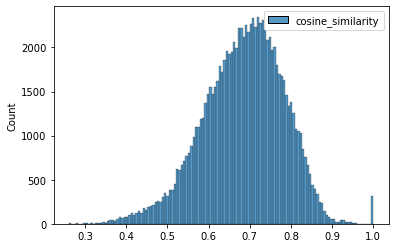

In [74]:
sns.histplot(cosims_df.sort_values('cosine_similarity', ascending = True));

In [76]:
(cosims_df
         [cosims_df['show'] != cosims_df['other_show']]
        .drop_duplicates(subset=['cosine_similarity'])
        .sort_values('cosine_similarity', ascending = False)[:20]
)

,show,other_show,cosine_similarity
82441,Tom Segura: Mostly Stories (2016) – Transcript,Tom Segura: Completely Normal (2014) – Transcript,0.966580
45807,AMY SCHUMER: LIVE AT THE APOLLO (2015) – Full ...,NIKKI GLASER: PERFECT (2016) – Full Transcript,0.962526
5433,Chris Rock: Tamborine (2018) – Transcript,Chris Rock Total Blackout: The Tamborine Exten...,0.956941
29065,AMY SCHUMER: MOSTLY SEX STUFF (2012) – Full Tr...,Chelsea Peretti: One of the Greats (2014) – Fu...,0.956930
73087,AMY SCHUMER: LIVE AT THE APOLLO (2015) – Full ...,AMY SCHUMER: MOSTLY SEX STUFF (2012) – Full Tr...,0.956720
45797,Donald Glover: Weirdo (2012) – Transcript,NIKKI GLASER: PERFECT (2016) – Full Transcript,0.953215
45805,AMY SCHUMER: MOSTLY SEX STUFF (2012) – Full Tr...,NIKKI GLASER: PERFECT (2016) – Full Transcript,0.953047
73119,AMY SCHUMER: THE LEATHER SPECIAL (2017) – Full...,AMY SCHUMER: MOSTLY SEX STUFF (2012) – Full Tr...,0.950953
23795,AMY SCHUMER: MOSTLY SEX STUFF (2012) – Full Tr...,Nikki Glaser: Bangin’ (2019) – Full Transcript,0.950099
23653,Chelsea Peretti: One of the Greats (2014) – Fu...,Nikki Glaser: Bangin’ (2019) – Full Transcript,0.948666


In [78]:
metascripts.loc[metascripts['description'] == "Tom Segura: Mostly Stories (2016) – Transcript", 'transcript'].values[0]

'  I love being a stand-up comedian. It\'s the best job in the world. And I love being an L.A. comic. Bam! Alfred the assassin. As a comic, what you\'re supposed to do is live your life and report it.  Anytime I do something nice for you, you shit on me! When is that?! I love the whole process.  You have a little dick. Writing. Performing. Figuring out how to make a joke work. It\'s the best. But most of all, I love meeting the people of this city. They always inspire me.  Hey! Tom Segura! Bite me in my ass, man! Aah! You have to do it! I love them. They have nothing but admiration for me.  Yeah, after work we can do whatever, man.  I just know there\'s no stopping us. Hey! Who this fat-ass nigger right here? What\'s up, fat boy? \'Sup? Making a food show, bitch? No. You should. Bam! \'Cause you fat as fuck! This fat motherfucker right here, man. You got pancake titties. You do! Fuck this city. I\'m re-shooting this thing. Eat a dick, Paul Blart. This fat motherfucker, man.  Ladies and

In [79]:
metascripts.loc[metascripts['description'] == "Tom Segura: Completely Normal (2014) – Transcript", 'transcript'].values[0]

'Ladies and gentlemen, Tom Segura! ` Thank you. Thanks a lot. Thank you. Very nice of you. Thank you. I hope I live up to your expectations. I realized today that I need a hobby, because my workday just started, like, now. Right now. I mean, here\'s the thing, it\'s not even that big a part of my day. So even if it doesn\'t go well, it\'s like, ah, you know, still a pretty good fucking day. Like, it was… wasn\'t a bad day. It just… you know, that part at work that, for an hour, just didn\'t go to my liking, and then I had a great day otherwise. \'Cause my whole life is basically, you know, it\'s… it\'s… it\'s hotels. Being in a hotel, just waiting for the show. Sad, right? I\'m just waiting for the show to start. And you\'re like, what… what am I gonna… I mean, you can only jerk off so many times before you\'re like, all right, I\'m gonna do it again, but… Right now it hurts. I should find something else to do. I absolutely ruin hotel rooms. Like, if you stay in a hotel room after I st

# playground
[to the top](#Feature-Engineering-for-Standup-Scripts)

### Remove brackets and parentheticals, as well as a check to ensure we don't accidentally remove too much
I'd also like to remove intro and exit music programmatically, but that's more fraught. Some shows deliberately contain music as content, and some scripts use an odd number of music signs, which makes it tough to single out lyrics.

In [ ]:
fake_tok = "Thank you, thank you. [applause, laughter] Have you heard what Florida man's up to?"
re.search(r"\[.+\]", fake_tok)

In [ ]:
re.sub(r"\[.+\]", "", fake_tok).strip()

In [ ]:
if fake_tok not in sw and re.search(r"\[.+\]", fake_tok):
    print("Yup, that's true")

In [ ]:
re.sub(r"\[.+?\]", "", transcripts_dict['Tom Papa: Human Mule (2016) – Transcript'])
re.search(r"♪.+?♪", transcripts_dict['Tom Papa: Human Mule (2016) – Transcript'])

In [ ]:
gen = (script for script in transcripts_dict.values())

In [ ]:
re.sub(r"\[.+?\]", "", re.sub(r"♪.+?♪", "", re.sub(r"♪♪.+?♪♪", "", transcripts_dict['Dave Chappelle: The Closer (2021) | Transcript'])))

In [ ]:
mm = metascripts.assign(
    modprop = lambda metascripts: (metascripts['script characters'] - metascripts['transcript'].replace("\[.+?\]|\(.+?\)","", regex = True).apply(len))/metascripts['script characters']
)

px.box(mm, x = 'modprop', hover_data = [mm.index, 'description'])

In [ ]:
metascripts['transcript'][32]

In [ ]:
metascripts['transcript'].replace("\[.+?\]|\(.+?\)","", regex = True)[32]